## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach

### Trial generalization ML models and analysis


### Package imports 

In [96]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import os
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import xgboost 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from inspect import signature
from scipy import interp
from pyitlib import discrete_random_variable as drv
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
import warnings
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore")

In [2]:
path = 'C:\\Users\\rk4\\Dropbox\\GAIT\\sample_data\\data_export\\'

In [3]:
#Reading the raw dataframe 
raw_df = pd.read_csv(path+'..\\..\\FinalCodes\\gait_features.csv', index_col = 0)
#Dropping the NaNs
raw_df.dropna(inplace = True)
#Resetting the index
raw_df.reset_index(inplace= True)
print ('Raw data shape: ', raw_df.shape)

#Reading the Size-N dataframe 
sizeN_df = pd.read_csv(path+'..\\..\\FinalCodes\\size_normalized_gait_features.csv', index_col = 0)
#Dropping the NaNs
sizeN_df.dropna(inplace = True)
#Resetting the index
sizeN_df.reset_index(inplace= True)
print ('Size-N data shape: ', sizeN_df.shape)

#Reading the Regress-N dataframe 
regressN_df = pd.read_csv(path+'..\\..\\FinalCodes\\mr_scaled_features_30controlsTrialW.csv', index_col = 0)
regressN_df.reset_index(inplace= True)
print('Regress-N data shape: ', regressN_df.shape)

#Delete the treadmill speeds as features since they are very very correlated with stride speed
#Also delete Butterfly plot y-direction features since COP_Y is not adjusted 
#Swing time and SS_L are the same
to_drop = ['tspeed_HSR', 'tspeed_MidSSR', 'tspeed_TOR', 'tspeed_HSL', 'tspeed_TOL', 'tspeed_MidSSL',  'Butterfly_y_abs', 
           'ButterflySQ_y', 'SS_L', 'index']
raw_df.drop(to_drop, axis = 1, inplace= True)
raw_df = shuffle(raw_df, random_state = 0)
print ('Raw data shape: ', raw_df.shape) #21 features + PID + Trial ID + Label = 24 features 

sizeN_df.drop(to_drop, axis = 1, inplace= True)
sizeN_df = shuffle(sizeN_df, random_state = 0)
print ('Size-N data shape: ', sizeN_df.shape) #21 features + PID + Trial ID + Label = 24 features 

regressN_df.drop(['index'], axis = 1, inplace = True)
regressN_df = shuffle(regressN_df, random_state = 0)
print('Regress-N data shape: ', regressN_df.shape)  #21 features + PID + Trial ID + Label = 24 features 

Raw data shape:  (3230, 34)
Size-N data shape:  (3230, 34)
Regress-N data shape:  (3230, 25)
Raw data shape:  (3230, 24)
Size-N data shape:  (3230, 24)
Regress-N data shape:  (3230, 24)


### Standardization

In [4]:
#Standardize the data before ML methods 
#Take care that testing set is not used while normalizaing the training set, otherwise the train set indirectly contains 
#information about the test set
def normalize(dataframe, n_type): 
    '''
    Input: dataframe, type of normalization (z-score or min-max)
    '''
    col_names = list(dataframe.columns)
    if (n_type == 'z'): #z-score normalization 
        mean = dataframe.mean()
        sd = dataframe.std()
    else: #min-max normalization
        mean = dataframe.min()
        sd = dataframe.max()-dataframe.min()
    return mean, sd

### Evaluation

In [92]:
def evaluate(model, test_features, trueY):
    test_labels = trueY['Label'] #Dropping the PID
    predictions = model.predict(test_features)
    try:
        prediction_prob = model.predict_proba(test_features)[:, 1] #Score of the class with greater label
    except:
        prediction_prob = model.best_estimator_._predict_proba_lr(test_features)[:, 1] #For linear SVM 
    #Stride wise metrics 
    acc = accuracy_score(test_labels, predictions)
    p = precision_score(test_labels, predictions)
    r = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
    auc = roc_auc_score(test_labels, prediction_prob)
    print('Stride-based model performance: ', acc, p, r, f1, auc)
    
    #For computing person wise metrics 
    temp = copy.deepcopy(trueY) #True label for the stride 
    temp['pred'] = predictions #Predicted label for the stride 
    #Correctly slassified strides i.e. 1 if stride is correctly classified and 0 if otherwise
    temp['correct'] = (temp['Label']==temp['pred'])

    #Proportion of correctly classified strides
    proportion_strides_correct = temp.groupby('PID').aggregate({'correct': 'mean'})  
    proportion_strides_correct['True Label'] = raw_testY.groupby('PID').first() 

    #Label for the person - 0=healthy, 1=MS patient
    proportion_strides_correct['Predicted Label'] = proportion_strides_correct['True Label']*\
    (proportion_strides_correct['correct']>0.5)+(1-proportion_strides_correct['True Label'])*\
    (proportion_strides_correct['correct']<0.5) 

    #Probability of class 1 - MS patient for AUC calculation
    proportion_strides_correct['prob_class1'] = (1-proportion_strides_correct['True Label'])*\
    (1-proportion_strides_correct['correct'])+ proportion_strides_correct['True Label']*proportion_strides_correct['correct'] 
    
    try:
        print (model.best_estimator_)
    except:
        pass
    #Person wise metrics 
    person_acc = accuracy_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_p = precision_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_r = recall_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_f1 = f1_score(proportion_strides_correct['True Label'], proportion_strides_correct['Predicted Label'])
    person_auc = roc_auc_score(proportion_strides_correct['True Label'], proportion_strides_correct['prob_class1'])
    print('Person-based model performance: ', person_acc, person_p, person_r, person_f1, person_auc)
    return proportion_strides_correct['prob_class1'], [acc, p, r, f1, auc, person_acc, person_p, person_r, person_f1, person_auc]

### ML models

#### Features are not normally distributed, hence LDA/QDA cannot be used as classifiers

In [93]:
#LDA/QDA were not used since the features are not normally disctributed for each cohort 
#Shapiro-Wilk test: p<0.05 fails the normality hypothesis 
# raw_df_features = raw_df[raw_df['Label']==0].drop(['PID', 'Label', 'TrialID'], axis = 1)
# raw_df_features=normalize(raw_df_features, 'z')

# for index in range(0, 21): #21 features 
#     print (stats.shapiro(raw_df_features.iloc[:, index])) #All p-values are less than 0.05 hence normality does not hold 

In [94]:
def models(trainX, trainY, testX, testY, model_name = 'random_forest'):
    '''
    training set: trainX, testX
    testing set: testX, testY
    model: model_name
    '''
    trainY1 = trainY['Label'] #Dropping the PID
    
    if(model_name == 'random_forest'): #Random Forest
        grid = {
       'n_estimators': [40,45,50],\
       'max_depth' : [15,20,25,None],\
       'class_weight': [None, 'balanced'],\
       'max_features': ['auto','sqrt','log2', None],\
       'min_samples_leaf':[1,2,0.1,0.05]
        }
        rf_grid = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator = rf_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv = 5)
    
    if(model_name == 'adaboost'): #Adaboost
        ada_grid = AdaBoostClassifier(random_state=0)
        grid = {
        'n_estimators':[50, 75, 100, 125, 150],\
        'learning_rate':[0.01,.1, 1, 1.5, 2]\
        }
        grid_search = GridSearchCV(ada_grid, param_grid = grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'kernel_svm'): #RBF SVM
        svc_grid = SVC(kernel = 'rbf', probability=True, random_state=0)
        grid = {
        'gamma':[0.0001, 0.001, 0.1, 1, 10, ]\
        }
        grid_search = GridSearchCV(svc_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)

    if(model_name == 'gbm'): #GBM
        gbm_grid = GradientBoostingClassifier(random_state=0)
        grid = {
        'learning_rate':[0.15,0.1,0.05], \
        'n_estimators':[50, 100, 150],\
        'max_depth':[2,4,7],\
        'min_samples_split':[2,4], \
        'min_samples_leaf':[1,3],\
        'max_features':[4, 5, 6]\
        }
        grid_search = GridSearchCV(gbm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name=='xgboost'): #Xgboost
        xgb_grid = xgboost.XGBClassifier(random_state=0)
        grid = {
            'min_child_weight': [1, 5],\
            'gamma': [0.1, 0.5, 1, 1.5, 2],\
            'subsample': [0.6, 0.8, 1.0],\
            'colsample_bytree': [0.6, 0.8, 1.0],\
            'max_depth': [5, 7, 8]
        }
        grid_search = GridSearchCV(xgb_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'knn'): #KNN
        knn_grid = KNeighborsClassifier()
        grid = {
            'n_neighbors': [1, 3, 4, 5, 10],\
            'p': [1, 2, 3, 4, 5]\
        }
        grid_search = GridSearchCV(knn_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    if(model_name == 'decision_tree'): #Decision Tree
        dec_grid = DecisionTreeClassifier(random_state=0)
        grid = {
            'min_samples_split': range(2, 50),\
        }
        grid_search = GridSearchCV(dec_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'linear_svm'): #Linear SVM
        lsvm_grid = LinearSVC(random_state=0)
        grid = {
            'loss': ['hinge','squared_hinge'],\

        }
        grid_search = GridSearchCV(lsvm_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
    
    if(model_name == 'logistic_regression'): #Logistic regression
        grid_search = LogisticRegression(random_state=0)
    
    if(model_name == 'mlp'):
        mlp_grid = MLPClassifier(activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init=0.001,\
                                                        shuffle=False, max_iter = 200, random_state = 0)
        grid = {
            'hidden_layer_sizes': [(128, 8, 8, 128, 32), (50, 50, 50, 50, 50, 50, 150, 100, 10), 
                                  (50, 50, 50, 50, 50, 60, 30, 20, 50), (50, 50, 50, 50, 50, 150, 10, 60, 150),
                                  (50, 50, 50, 50, 50, 5, 50, 10, 5), (50, 50, 50, 50, 50, 5, 50, 150, 150),
                                  (50, 50, 50, 50, 50, 5, 30, 50, 20), (50, 50, 50, 50, 10, 150, 20, 20, 30),
                                  (50, 50, 50, 50, 30, 150, 100, 20, 100), (50, 50, 50, 50, 30, 5, 100, 20, 100),
                                  (50, 50, 50, 50, 60, 50, 50, 60, 60), (50, 50, 50, 50, 20, 50, 60, 20, 20),
                                  (50, 50, 50, 10, 50, 10, 150, 60, 150), (50, 50, 50, 10, 50, 150, 30, 150, 5),
                                  (50, 50, 50, 10, 50, 20, 150, 5, 10), (50, 50, 50, 10, 150, 50, 20, 20, 100), 
                                  (50, 50, 50, 30, 100, 5, 30, 150, 30), (50, 50, 50, 50, 100, 150, 100, 200), 
                                  (50, 50, 50, 5, 5, 100, 100, 150), (50, 50, 5, 50, 200, 100, 150, 5), 
                                  (50, 50, 5, 5, 200, 100, 50, 30), (50, 50, 5, 10, 5, 200, 200, 10), 
                                  (50, 50, 5, 30, 5, 5, 50, 10), (50, 50, 5, 200, 50, 5, 5, 50), 
                                  (50, 50,50, 5, 5, 100, 100, 150), (5, 5, 5, 5, 5, 100, 50, 5, 50, 50), 
                                  (5, 5, 5, 5, 5, 100, 20, 100, 30, 30), (5, 5, 5, 5, 5, 20, 20, 5, 30, 100), 
                                  (5, 5, 5, 5, 5, 20, 20, 100, 10, 10), (5, 5, 5, 5, 10, 10, 30, 50, 10, 10), 
                                  (5, 5, 5, 5, 10, 100, 30, 30, 30, 10), (5, 5, 5, 5, 10, 100, 50, 10, 50, 10), 
                                  (5, 5, 5, 5, 10, 100, 20, 100, 30, 5), (5, 5, 5, 5, 30, 5, 20, 30, 100, 50), 
                                  (5, 5, 5, 5, 30, 100, 20, 50, 20, 30), (5, 5, 5, 5, 50, 30, 5, 50, 10, 100), 
                                  (21, 21, 7, 84, 21, 84, 84), (21, 21, 5, 42, 42, 7, 42), (21, 84, 7, 7, 7, 84, 5), 
                                  (21, 7, 84, 5, 5, 21, 120), (42, 5, 21, 21, 21, 5, 120), (42, 5, 42, 84, 7, 120, 84), 
                                  (50, 100, 10, 5, 100, 25), (10, 10, 25, 50, 25, 5), (50, 50, 50, 50, 50, 20, 30, 100, 60)]

        }
        grid_search = GridSearchCV(mlp_grid, param_grid=grid, scoring='accuracy', n_jobs = 1, cv=5)
        
    grid_search.fit(trainX, trainY1) #Fitting on the training set to find the optimal hyperparameters 
#     print('best score: ', grid_search.best_score_)
#     print('best_params: ', grid_search.best_params_, grid_search.best_index_)
#     print('Mean cv accuracy on test set:', grid_search.cv_results_['mean_test_score'][grid_search.best_index_])
#     print('Standard deviation on test set:' , grid_search.cv_results_['std_test_score'][grid_search.best_index_])
#     print('Mean cv accuracy on train set:', grid_search.cv_results_['mean_train_score'][grid_search.best_index_])
#     print('Standard deviation on train set:', grid_search.cv_results_['std_train_score'][grid_search.best_index_])
#     print('Test set performance:\n')
    stride_person_metrics = evaluate(grid_search, testX, testY)
    return stride_person_metrics

### Raw data

In [8]:
#Trial W for training 
raw_trial1 = raw_df[raw_df['TrialID']==1]
raw_trainX = raw_trial1.drop(['Label', 'PID', 'TrialID'], axis = 1)
raw_trainY = raw_trial1[['PID', 'Label']]

#Trial WT for testing 
raw_trial2 = raw_df[raw_df['TrialID']==2]
raw_testX = raw_trial2.drop(['Label', 'PID', 'TrialID'], axis = 1)
raw_testY = raw_trial2[['PID', 'Label']] #PID to compute person based metrics later 

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(raw_trainX, 'z')
raw_trainX_norm = (raw_trainX-norm_mean)/norm_sd
raw_testX_norm = (raw_testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(raw_trainY))
print ('Control strides in training set: ', len(raw_trainY)-raw_trainY['Label'].sum())
print('MS strides in training set: ', raw_trainY['Label'].sum())

#Test Set
print('Strides in test set: ', len(raw_testY)) 
print ('Control strides in test set: ', len(raw_testY)-raw_testY['Label'].sum())
print('MS strides in test set: ', raw_testY['Label'].sum())
print ('Imbalance ratio (controls:MS)= 1:', raw_testY['Label'].sum()/(len(raw_testY)-raw_testY['Label'].sum()))

Strides in training set:  1654
Control strides in training set:  905
MS strides in training set:  749
Strides in test set:  1576
Control strides in test set:  878
MS strides in test set:  698
Imbalance ratio (controls:MS)= 1: 0.7949886104783599


In [9]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression']
raw_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
predicted_probs_person_raw = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(raw_trainX_norm, raw_trainY, raw_testX_norm, raw_testY, ml_model)
    raw_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_raw[ml_model] = predict_probs_person
    print ('********************************')

raw_metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
raw_metrics.to_csv(path+'..//trial_generalize//trial_generalize_results_raw_data.csv')
predicted_probs_person_raw.to_csv(path+'..//trial_generalize//trial_generalize_ROCresults_raw_data.csv')

random_forest
Stride-based model performance:  0.8375634517766497 0.8452722063037249 0.7994579945799458 0.8217270194986073 0.9213364249303249
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Person-based model performance:  0.8857142857142857 0.8823529411764706 0.8823529411764706 0.8823529411764706 0.9738562091503268
********************************
adaboost
Stride-based model performance:  0.7982233502538071 0.8151862464183381 0.7506596306068601 0.7815934065934067 0.887645142972763
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=150, random_state=0)
Person-based model performance:  0.88

In [10]:
raw_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression
stride_accuracy,0.837563,0.798223,0.828046,0.862944,0.861041,0.827411,0.772843,0.687817,0.674492
stride_precision,0.845272,0.815186,0.898281,0.862464,0.865330,0.838109,0.752149,0.498567,0.500000
stride_recall,0.799458,0.750660,0.758162,0.833795,0.828532,0.786290,0.739437,0.710204,0.680312
stride_F1,0.821727,0.781593,0.822295,0.847887,0.846531,0.811373,0.745739,0.585859,0.576383
stride_AUC,0.921336,0.887645,0.899833,0.939536,0.936920,0.828508,0.784134,0.717540,0.724672
person_accuracy,0.885714,0.885714,1.000000,0.942857,0.942857,1.000000,0.885714,0.742857,0.742857
person_precision,0.882353,0.941176,1.000000,0.941176,0.941176,1.000000,0.882353,0.529412,0.588235
person_recall,0.882353,0.842105,1.000000,0.941176,0.941176,1.000000,0.882353,0.900000,0.833333
person_F1,0.882353,0.888889,1.000000,0.941176,0.941176,1.000000,0.882353,0.666667,0.689655
person_AUC,0.973856,0.980392,1.000000,0.990196,0.993464,1.000000,0.960784,0.843137,0.813725


### Size-N data

In [9]:
#Trial W for training 
sizeN_trial1 = sizeN_df[sizeN_df['TrialID']==1]
sizeN_trainX = sizeN_trial1.drop(['Label', 'PID', 'TrialID'], axis = 1)
sizeN_trainY = sizeN_trial1[['PID', 'Label']]

#Trial WT for testing 
sizeN_trial2 = sizeN_df[sizeN_df['TrialID']==2]
sizeN_testX = sizeN_trial2.drop(['Label', 'PID', 'TrialID'], axis = 1)
sizeN_testY = sizeN_trial2[['PID', 'Label']] #PID to compute person based metrics later 

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(sizeN_trainX, 'z')
sizeN_trainX_norm = (sizeN_trainX-norm_mean)/norm_sd
sizeN_testX_norm = (sizeN_testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(sizeN_trainY))
print ('Control strides in training set: ', len(sizeN_trainY)-sizeN_trainY['Label'].sum())
print('MS strides in training set: ', sizeN_trainY['Label'].sum())

#Test Set
print('Strides in test set: ', len(sizeN_testY)) 
print ('Control strides in test set: ', len(sizeN_testY)-sizeN_testY['Label'].sum())
print('MS strides in test set: ', sizeN_testY['Label'].sum())
print ('Imbalance ratio (controls:MS)= 1:', sizeN_testY['Label'].sum()/(len(sizeN_testY)-sizeN_testY['Label'].sum()))

Strides in training set:  1654
Control strides in training set:  905
MS strides in training set:  749
Strides in test set:  1576
Control strides in test set:  878
MS strides in test set:  698
Imbalance ratio (controls:MS)= 1: 0.7949886104783599


In [12]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression']
sizeN_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
predicted_probs_person_sizeN = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(sizeN_trainX_norm, sizeN_trainY, sizeN_testX_norm, sizeN_testY, ml_model)
    sizeN_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_sizeN[ml_model] = predict_probs_person
    print ('********************************')

sizeN_metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
sizeN_metrics.to_csv(path+'..//trial_generalize//trial_generalize_results_sizeN_data.csv')
predicted_probs_person_sizeN.to_csv(path+'..//trial_generalize//trial_generalize_ROCresults_sizeN_data.csv')

random_forest
Stride-based model performance:  0.743020304568528 0.666189111747851 0.7299843014128728 0.696629213483146 0.841233658157704
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Person-based model performance:  0.8285714285714286 0.7058823529411765 0.9230769230769231 0.8000000000000002 0.9346405228758169
********************************
adaboost
Stride-based model performance:  0.7112944162436549 0.6088825214899714 0.700164744645799 0.6513409961685824 0.7550029044911919
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=0)
Person-based model pe

In [13]:
sizeN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression
stride_accuracy,0.743020,0.711294,0.744289,0.786802,0.784264,0.718274,0.692259,0.678299,0.682107
stride_precision,0.666189,0.608883,0.779370,0.716332,0.732092,0.630372,0.616046,0.444126,0.507163
stride_recall,0.729984,0.700165,0.686003,0.783699,0.769578,0.702875,0.664606,0.722611,0.692759
stride_F1,0.696629,0.651341,0.729712,0.748503,0.750367,0.664653,0.639405,0.550133,0.585608
stride_AUC,0.841234,0.755003,0.818954,0.866880,0.866592,0.779552,0.698845,0.729496,0.745999
person_accuracy,0.828571,0.800000,0.857143,0.942857,0.885714,0.857143,0.771429,0.771429,0.742857
person_precision,0.705882,0.647059,0.882353,0.882353,0.823529,0.705882,0.705882,0.529412,0.529412
person_recall,0.923077,0.916667,0.833333,1.000000,0.933333,1.000000,0.800000,1.000000,0.900000
person_F1,0.800000,0.758621,0.857143,0.937500,0.875000,0.827586,0.750000,0.692308,0.666667
person_AUC,0.934641,0.918301,0.980392,1.000000,0.980392,0.947712,0.892157,0.816993,0.833333


In [10]:
sizeN_metrics = pd.read_csv(path+'..//trial_generalize//trial_generalize_results_sizeN_data.csv')
predicted_probs_person_sizeN= pd.read_csv(path+'..//trial_generalize//trial_generalize_ROCresults_sizeN_data.csv')

In [95]:
#MLP on size-N 
ml_models = ['mlp']

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(sizeN_trainX_norm, sizeN_trainY, sizeN_testX_norm, sizeN_testY, ml_model)
    sizeN_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_sizeN[ml_model] = predict_probs_person.values
    print ('********************************')

mlp
Stride-based model performance:  0.7455583756345178 0.7422512234910277 0.6518624641833811 0.6941266209000762 0.8200814562923028
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(128, 8, 8, 128, 32), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=False,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
Person-based model performance:  0.8285714285714286 0.9230769230769231 0.7058823529411765 0.8000000000000002 0.9509803921568627
********************************


In [ ]:
sizeN_metrics.index = sizeN_metrics['Unnamed: 0']
sizeN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

### Regress-N data

In [15]:
#Trial W for training 
regressN_trial1 = regressN_df[regressN_df['TrialID']==1]
regressN_trainX = regressN_trial1.drop(['Label', 'PID', 'TrialID'], axis = 1)
regressN_trainY = regressN_trial1[['PID', 'Label']]

#Trial WT for testing 
regressN_trial2 = regressN_df[regressN_df['TrialID']==2]
regressN_testX = regressN_trial2.drop(['Label', 'PID', 'TrialID'], axis = 1)
regressN_testY = regressN_trial2[['PID', 'Label']] #PID to compute person based metrics later 

#Normalize according to z-score standardization
norm_mean, norm_sd = normalize(regressN_trainX, 'z')
regressN_trainX_norm = (regressN_trainX-norm_mean)/norm_sd
regressN_testX_norm = (regressN_testX-norm_mean)/norm_sd

#Total strides and imbalance of labels in the training and testing set
#Training set 
print('Strides in training set: ', len(regressN_trainY))
print ('Control strides in training set: ', len(regressN_trainY)-regressN_trainY['Label'].sum())
print('MS strides in training set: ', regressN_trainY['Label'].sum())

#Test Set
print('Strides in test set: ', len(regressN_testY)) 
print ('Control strides in test set: ', len(regressN_testY)-regressN_testY['Label'].sum())
print('MS strides in test set: ', regressN_testY['Label'].sum())
print ('Imbalance ratio (controls:MS)= 1:', regressN_testY['Label'].sum()/(len(regressN_testY)-regressN_testY['Label'].sum()))

Strides in training set:  1654
Control strides in training set:  905
MS strides in training set:  749
Strides in test set:  1576
Control strides in test set:  878
MS strides in test set:  698
Imbalance ratio (controls:MS)= 1: 0.7949886104783599


In [15]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression']
regressN_metrics = pd.DataFrame(columns = ml_models) #Dataframe to store accuracies for each ML model for raw data 
#For storing predicted probabilities for person (for class 1) to show ROC curves 
predicted_probs_person_regressN = pd.DataFrame(columns = ml_models) 

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(regressN_trainX_norm, regressN_trainY, regressN_testX_norm, regressN_testY, ml_model)
    regressN_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_regressN[ml_model] = predict_probs_person
    print ('********************************')

regressN_metrics.index = ['stride_accuracy', 'stride_precision', 'stride_recall', 'stride_F1', 'stride_AUC', 'person_accuracy', 
                     'person_precision', 'person_recall', 'person_F1', 'person_AUC']  
regressN_metrics.to_csv(path+'..//trial_generalize//trial_generalize_results_regressN_data.csv')
predicted_probs_person_regressN.to_csv(path+'..//trial_generalize//trial_generalize_ROCresults_regressN_data.csv')

random_forest
Stride-based model performance:  0.7918781725888325 0.7134670487106017 0.7955271565495208 0.7522658610271903 0.8858167820848373
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Person-based model performance:  0.9428571428571428 0.8823529411764706 1.0 0.9375 0.9869281045751634
********************************
adaboost
Stride-based model performance:  0.7677664974619289 0.6848137535816619 0.7660256410256411 0.7231467473524961 0.8446570415962301
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=100, random_state=0)
Person-based model performance:  0.88571428

In [16]:
regressN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression
stride_accuracy,0.791878,0.767766,0.784898,0.824239,0.814721,0.773477,0.731599,0.728426,0.727157
stride_precision,0.713467,0.684814,0.840974,0.729226,0.734957,0.742120,0.674785,0.604585,0.594556
stride_recall,0.795527,0.766026,0.720245,0.852596,0.827419,0.745324,0.706147,0.735192,0.738434
stride_F1,0.752266,0.723147,0.775942,0.786100,0.778452,0.743719,0.690110,0.663522,0.658730
stride_AUC,0.885817,0.844657,0.868422,0.910321,0.901481,0.770263,0.748806,0.809718,0.806809
person_accuracy,0.942857,0.885714,0.942857,0.942857,0.914286,0.942857,0.800000,0.800000,0.771429
person_precision,0.882353,0.764706,0.941176,0.882353,0.823529,0.882353,0.647059,0.647059,0.588235
person_recall,1.000000,1.000000,0.941176,1.000000,1.000000,1.000000,0.916667,0.916667,0.909091
person_F1,0.937500,0.866667,0.941176,0.937500,0.903226,0.937500,0.758621,0.758621,0.714286
person_AUC,0.986928,1.000000,0.996732,1.000000,1.000000,1.000000,0.954248,0.872549,0.856209


In [16]:
regressN_metrics = pd.read_csv(path+'..//trial_generalize//trial_generalize_results_regressN_data.csv')
predicted_probs_person_regressN= pd.read_csv(path+'..//trial_generalize//trial_generalize_ROCresults_regressN_data.csv')

In [83]:
predicted_probs_person_regressN[['PID', 'gbm']]

,PID,gbm
0,200,0.044444
1,201,0.176471
2,202,0.027027
3,203,0.023810
4,204,0.035714
5,205,0.178571
6,206,0.057692
7,207,0.115385
8,208,0.212766
9,209,0.166667


In [90]:
#MLP on regress-N 
ml_models = ['mlp']

for ml_model in ml_models:
    print (ml_model)
    predict_probs_person, stride_person_metrics = models(regressN_trainX_norm, regressN_trainY, regressN_testX_norm, regressN_testY, ml_model)
    regressN_metrics[ml_model] = stride_person_metrics
    predicted_probs_person_regressN[ml_model] = predict_probs_person.values
    print ('********************************')


mlp
Stride-based model performance:  0.7950507614213198 0.8544423440453687 0.6475644699140402 0.736756316218419 0.8780815346156607
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50, 50, 50, 20, 30, 100, 60),
       learning_rate='adaptive', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=0,
       shuffle=False, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Person-based model performance:  0.8857142857142857 1.0 0.7647058823529411 0.8666666666666666 0.9738562091503268
********************************


In [91]:
regressN_metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
Unnamed: 0,,,,,,,,,,
stride_accuracy,0.791878,0.767766,0.784898,0.824239,0.814721,0.773477,0.731599,0.728426,0.727157,0.795051
stride_precision,0.713467,0.684814,0.840974,0.729226,0.734957,0.742120,0.674785,0.604585,0.594556,0.854442
stride_recall,0.795527,0.766026,0.720245,0.852596,0.827419,0.745324,0.706147,0.735192,0.738434,0.647564
stride_F1,0.752266,0.723147,0.775942,0.786100,0.778452,0.743719,0.690110,0.663522,0.658730,0.736756
stride_AUC,0.885817,0.844657,0.868422,0.910321,0.901481,0.770263,0.748806,0.809718,0.806809,0.878082
person_accuracy,0.942857,0.885714,0.942857,0.942857,0.914286,0.942857,0.800000,0.800000,0.771429,0.885714
person_precision,0.882353,0.764706,0.941176,0.882353,0.823529,0.882353,0.647059,0.647059,0.588235,1.000000
person_recall,1.000000,1.000000,0.941176,1.000000,1.000000,1.000000,0.916667,0.916667,0.909091,0.764706
person_F1,0.937500,0.866667,0.941176,0.937500,0.903226,0.937500,0.758621,0.758621,0.714286,0.866667


In [24]:
regressN_metrics.index = regressN_metrics['Unnamed: 0']
regressN_metrics.drop('Unnamed: 0', axis = 1, inplace = True)

### ROC curves for cohort prediction

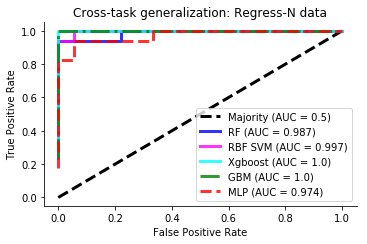

In [79]:
ml_models = ['random_forest',  'kernel_svm',  'xgboost', 'gbm', 'mlp'] 
#, 'adaboost', 'linear_svm', 'decision_tree', 'logistic_regression',] 
#'knn', 
ml_model_names = {'random_forest': 'RF', 'adaboost': 'Adaboost', 'kernel_svm': 'RBF SVM', 'gbm': 'GBM', \
                  'xgboost': 'Xgboost', 'knn': 'KNN', 'decision_tree': 'DT',  'linear_svm': 'LSVM', 
             'logistic_regression': 'LR', 'mlp': 'MLP'}
person_true_labels = raw_testY.groupby('PID').first()
neutral = [0 for _ in range(len(person_true_labels))] # ROC for majority class prediction all the time 

fig, axes = plt.subplots(1, 1, sharex=True, sharey = True, figsize=(5.2, 3.5))
sns.despine(offset=0)
neutral_fpr, neutral_tpr, _ = roc_curve(person_true_labels, neutral) #roc curves
# #Raw Data 
# axes[0].plot(neutral_fpr, neutral_tpr, linestyle='--', label='Majority (AUC = 0.5)', linewidth = 2, color = 'k')
# for ml_model in ml_models:
#     model_probs = predicted_probs_person_raw[ml_model] # person-based prediction probabilities
#     fpr, tpr, _ = roc_curve(person_true_labels, model_probs)
#     axes[0].plot(fpr, tpr, label=ml_model_names[ml_model]+' (AUC = '+ str(round(raw_metrics.loc['person_AUC'][ml_model], 3))
#                  +')', linewidth = 2)
# axes[0].set_ylabel('True Positive Rate')
# axes[0].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)
# axes[0].set_title('Raw data')

linestyles = ['-', '-', '-', '-.', '--', '-', '--', '-', '--']
colors = ['b', 'magenta', 'cyan', 'g',  'red', 'violet', 'lime', 'grey', 'pink']

# #SizeN Data 
# axes[0].plot(neutral_fpr, neutral_tpr, linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
# for idx, ml_model in enumerate(ml_models):
#     model_probs = predicted_probs_person_sizeN[ml_model] # person-based prediction probabilities
#     fpr, tpr, _ = roc_curve(person_true_labels, model_probs)
#     axes[0].plot(fpr, tpr, label=ml_model_names[ml_model]+' (AUC = '+ str(round(sizeN_metrics.loc['person_AUC'][ml_model], 3))
#                  +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[idx], color = colors[idx])
# # axes[0].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)
# axes[0].legend()
# axes[0].set_ylabel('True Positive Rate')
# axes[0].set_title('Size-N data')

#RegressN Data 
axes.plot(neutral_fpr, neutral_tpr, linestyle='--', label='Majority (AUC = 0.5)', linewidth = 3, color = 'k')
for idx, ml_model in enumerate(ml_models):
    model_probs = predicted_probs_person_regressN[ml_model] # person-based prediction probabilities
    fpr, tpr, _ = roc_curve(person_true_labels, model_probs)
    axes.plot(fpr, tpr, label=ml_model_names[ml_model]+' (AUC = '+ str(round(regressN_metrics.loc['person_AUC'][ml_model], 3))
                 +')', linewidth = 3, alpha = 0.8, linestyle = linestyles[idx], color = colors[idx])
axes.set_ylabel('True Positive Rate')
axes.set_title('Cross-task generalization: Regress-N data')
plt.legend()
# axes[1].legend(loc='upper center', bbox_to_anchor=(1.27, 1), ncol=1)

axes.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig(path + '..//trial_generalize//ROC_trial_generalize_onlyregressN.png', dpi = 250)
plt.show()

### Correlation between proportion of correctly classified strides for subjects vs EDSS/age/walking speed